In [1]:
import warnings, random, gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from keras import layers

MAX_EPISODE = 500
PPO_EPOCHS = 3
PPO_ITERS = 64
PPO_BATCH_SIZE = 16
GAMMA = 0.99
LAMBDA = 0.95
EPS = 1e-8

warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-12-06 18:55:22.121709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:55:22.722959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
env = gym.make("LunarLander-v2")
states_shape = env.observation_space.shape[0]
n_actions = env.action_space.n

In [3]:
def get_actor_critic_model(input_shape, actor_out_shape, hidden_size):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(hidden_size, activation='relu')(inputs)
    x = layers.Dense(hidden_size, activation='relu')(x)
    actor = layers.Dense(actor_out_shape, activation='softmax', name='actor')(x)
    critic = layers.Dense(1, activation='linear', name='critic')(x)

    return keras.Model(inputs=inputs, outputs=[actor,critic])

In [4]:
class Memory:
    def __init__(self, maxlen):
        super(Memory, ).__init__()
        self.maxlen = maxlen
        self.idx = 0

        self.states = np.zeros((maxlen, states_shape))
        self.actions = np.zeros(maxlen, dtype=np.uint8)
        self.log_probs = np.zeros(maxlen)
        self.critic_values = np.zeros(maxlen+1)
        self.rewards = np.zeros(maxlen)
        self.dones = np.zeros(maxlen)
        
    
    def store(self, state, action, log_prob, critic_value, reward, done):
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.log_probs[self.idx] = log_prob
        self.critic_values[self.idx] = critic_value
        self.rewards[self.idx] = reward
        self.dones[self.idx] = done
        self.idx += 1

    def free_memory(self):
        self.idx = 0

    def sample(self, batch_size):
        batch_samples = random.sample(self.buffer, batch_size)
        
        states = [sample[0] for sample in batch_samples]
        actions = [sample[1] for sample in batch_samples]
        rewards = [sample[2] for sample in batch_samples]
        next_states = [sample[3] for sample in batch_samples]
        dones = [sample[4] for sample in batch_samples]
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [13]:
class PPO:
    def __init__(self, actor_critic, optimizer, n_steps, epochs, minibacth_size, epsilon):
        self.actor_critic = actor_critic
        self.optim = optimizer

        self.n_steps = n_steps
        self.epochs = epochs
        self.minibacth_size = (int(n_steps/minibacth_size), minibacth_size)
        self.clip_max = 1 + epsilon
        self.clip_min = 1 - epsilon
        self.c1 = 1
        self.c2 = 0.01

    def compute_gae(self, rewards, critic_values, dones):
        gae_step = 0
        andavtages = np.zeros(self.n_steps)
        for t in reversed(range(self.n_steps-1)):
            delta = rewards[t] + GAMMA * critic_values[t+1] * (1-dones[t]) - critic_values[t]
            gae_step = delta + GAMMA * LAMBDA * (1-dones[t]) * gae_step
            andavtages[t] = gae_step

        return andavtages
    
    def update(self, states, actions, log_probabilities, critic_values, gaes):
        losses = []
        for epoch in range(self.epochs):
            batch_idxs = np.random.choice(range(self.n_steps), size=self.minibacth_size, replace=False)

            for idxs in batch_idxs:
                states_batch = states[idxs]
                # this structure is used to gather the action probabilites below
                actions_batch = [[i, actions[idx]] for i,idx in enumerate(idxs)] 
                log_probs_batch = log_probabilities[idxs]
                critic_values_batch = critic_values[idxs]
                gaes_batch = gaes[idxs]

                with tf.GradientTape() as tape:
                    probs, values = self.actor_critic(states_batch)
                    log_probs = tf.math.log(tf.gather_nd(probs, actions_batch))
                    
                    # actor loss
                    ratio = tf.math.exp(log_probs - log_probs_batch)
                    advantage = gaes_batch - critic_values_batch
                    l_clip = - tf.math.minimum(
                        ratio * advantage,                                                  # normal ratio
                        tf.clip_by_value(ratio, self.clip_min, self.clip_max) * advantage   # clip term
                    )

                    # critic loss
                    l_vf = keras.losses.mean_squared_error(gaes, values)

                    # entropy term
                    s = - tf.reduce_sum(probs * tf.math.log(probs), axis=-1)
                    
                    loss =  tf.reduce_mean(
                        l_clip + self.c1 * l_vf + self.c2 * s
                    )
                    print(loss.numpy())

                gradients = tape.gradient(loss, self.actor_critic.trainable_variables)
                self.optim.apply_gradients(zip(gradients, self.actor_critic.trainable_variables))
        
        return losses


In [14]:
actor_critic = get_actor_critic_model(input_shape=states_shape,
                                      actor_out_shape=n_actions,
                                      hidden_size=32)
# actor_critic.summary()

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)

running_reward = 0
memory = Memory(PPO_ITERS)
ppo = PPO(actor_critic=actor_critic,
          optimizer=optimizer,
          n_steps=PPO_ITERS,
          epochs=PPO_EPOCHS,
          minibacth_size=PPO_BATCH_SIZE,
          epsilon=0.2
)

episode_rewards = []
running_rewards = []
episode_losses = []

for episode in range(1, MAX_EPISODE+1):
    state, _ = env.reset()
    episode_reward = 0
    
    # Collect trajectory
    for t in range(PPO_ITERS):
        state = tf.expand_dims(state, 0)
        
        actions_prob, critic_val = actor_critic(state)
        action = np.random.choice(n_actions, p=np.squeeze(actions_prob.numpy()))

        next_state, reward, done, _, _ = env.step(action)

        memory.store(state, action, tf.math.log(actions_prob[0, action]), critic_val[0,0].numpy(), reward, int(done))
        episode_reward += reward

        if done:
            state, _ = env.reset()
            continue

        state = next_state
    
    # compute gae
    memory.critic_values[PPO_ITERS] = tf.squeeze(actor_critic(tf.expand_dims(next_state, 0))[1]).numpy()
    gaes = ppo.compute_gae(memory.rewards, memory.critic_values, memory.dones)
    gaes = (gaes - gaes.mean()) / (gaes.std() + EPS)

    losses = ppo.update(memory.states, memory.actions, memory.log_probs, memory.critic_values, gaes)

    episode_losses.append(losses)
    memory.free_memory()

    episode_rewards.append(episode_reward)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    running_rewards.append(running_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}:\tavg_episode_reward={np.mean(episode_rewards[-50:]):.1f}\trunning_reward={running_reward:.1f}")
    if running_reward > 200: #termination condition
        print(f"Solved at {episode} episode: trunning_reward={running_reward}!")
        break
    if episode % 1000 == 0:
        clear_output()

actor_critic.save_weights("checkpoints/ppo_lunarlander.h5")

1.0581534
0.8193579
1.3449492
0.78271
1.0545617
1.050609
1.1004573
0.6856959
0.802524
1.1485722
1.1947452
0.70782614
1.22562
1.0953567
1.0079486
1.050696
0.9921774
1.3045354
0.8059418
1.2438357
1.072554
1.3372949
0.9454335
0.98295236
0.8948219
0.8472706
1.0616969
0.99958163
0.80867887
1.3178141
1.0557902
0.51241344
0.63681203
0.7165946
1.1591964
1.1071584
0.8764591
0.5428276
1.1649802
1.1481303
0.8705183
0.6050239
0.8322269
1.393615
0.91751266
1.0902522
0.5604467
1.0831894
0.816335
1.2842818
0.6795835
1.1830924
0.6912669
1.1481054
1.0857928
0.9482036
1.2106259
0.9799092
0.9732188
0.6625188
1.1529566
1.2434863
0.8265163
0.6103629
1.0545553
1.0759281
0.9814389
0.6603035
0.9942466
1.2148601
0.8088555
0.7154887
0.96673363
0.9571858
1.328793
1.0904155
1.0795294
1.4329909
0.9696783
0.78758204
1.2040086
0.869643
1.2848195
0.8651845
1.2832068
1.0518464
0.61936796
1.1726072
0.8793841
1.3145111
1.1778871
0.5697825
1.0833216
1.1883328
1.0001487
0.68545026
0.98708045
0.8062003
1.2144916
1.0009283


KeyboardInterrupt: 

In [ ]:
len(losses)

40

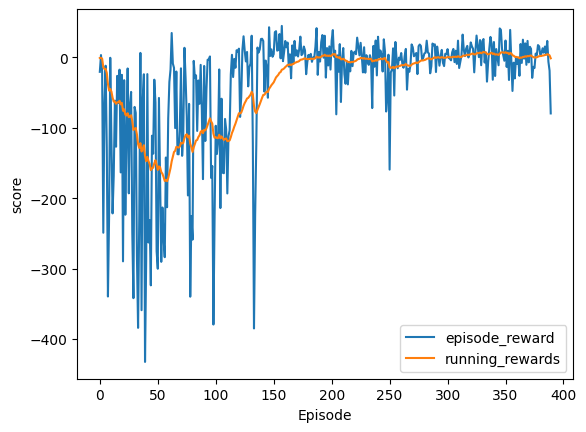

In [ ]:
plt.plot(episode_rewards, label='episode_reward')
plt.plot(running_rewards, label='running_rewards')
plt.ylabel('score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [ ]:
loss

NameError: name 'loss' is not defined

In [ ]:
state, _ = env.reset()

In [ ]:
state = tf.expand_dims(state, 0)
        
actions_prob, critic_val = actor_critic(state)
actions_prob, critic_val

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[nan, nan, nan, nan]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[nan]], dtype=float32)>)